In [4]:
from typing import Optional, Tuple, List, Dict, Any
import numpy as np
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from ripser import ripser
from persim import plot_diagrams, bottleneck, wasserstein
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("attack_pairs.csv")
df.head()

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,[[lovingly]] photographed in the manner of a g...,[[affectionately]] photographed in the manner ...,0.062279,0.761633,1,0,1,86,Successful
1,consistently clever and [[suspenseful]] .,consistently clever and [[nightmarish]] .,0.049463,0.510562,1,0,1,10,Successful
2,"it's like a "" big chill "" reunion of the baade...","it's like a "" big chill "" reunion of the baade...",0.855187,0.855187,0,0,1,1,Skipped
3,the story [[gives]] ample opportunity for larg...,the story [[offered]] ample opportunity for la...,0.057160,0.523163,1,0,1,183,Successful
4,"red dragon "" never cuts corners .","red dragon "" never cuts corners .",0.851783,0.851783,0,0,1,1,Skipped


In [6]:
# clean double brackets like [[word]] inserted by TextAttack and save as new columns
df['original_text_clean'] = (
    df['original_text']
    .astype(str)
    .str.replace(r'\[\[\s*(.*?)\s*\]\]', r'\1', regex=True)  # replace [[...]] with ...
    .str.replace(r'\[\[|\]\]', '', regex=True)               # remove any leftover brackets
    .str.strip()
)

df['perturbed_text_clean'] = (
    df['perturbed_text']
    .astype(str)
    .str.replace(r'\[\[\s*(.*?)\s*\]\]', r'\1', regex=True)
    .str.replace(r'\[\[|\]\]', '', regex=True)
    .str.strip()
)

# quick check
df[['original_text', 'original_text_clean', 'perturbed_text', 'perturbed_text_clean']].head()

,original_text,original_text_clean,perturbed_text,perturbed_text_clean
0,[[lovingly]] photographed in the manner of a g...,lovingly photographed in the manner of a golde...,[[affectionately]] photographed in the manner ...,affectionately photographed in the manner of a...
1,consistently clever and [[suspenseful]] .,consistently clever and suspenseful .,consistently clever and [[nightmarish]] .,consistently clever and nightmarish .
2,"it's like a "" big chill "" reunion of the baade...","it's like a "" big chill "" reunion of the baade...","it's like a "" big chill "" reunion of the baade...","it's like a "" big chill "" reunion of the baade..."
3,the story [[gives]] ample opportunity for larg...,the story gives ample opportunity for large-sc...,the story [[offered]] ample opportunity for la...,the story offered ample opportunity for large-...
4,"red dragon "" never cuts corners .","red dragon "" never cuts corners .","red dragon "" never cuts corners .","red dragon "" never cuts corners ."


In [7]:
# filter for successful attacks and sort by absolute score difference (descending)
df_success = df[df['result_type'] == 'Successful'].copy()
df_success['abs_score_diff'] = (df_success['original_score'] - df_success['perturbed_score']).abs()
df_success_sorted = df_success.sort_values(by='abs_score_diff', ascending=False)

# show top rows
df_success_sorted.head()

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type,original_text_clean,perturbed_text_clean,abs_score_diff
845,in [[terms]] of execution this [[movie]] is [[...,in [[expressions]] of execution this [[drama]]...,0.107378,0.954713,0,1,0,163,Successful,in terms of execution this movie is careless a...,in expressions of execution this drama is care...,0.847335
9,generates an [[enormous]] feeling of empathy f...,generates an [[gargantuan]] feeling of empathy...,0.052562,0.897856,1,0,1,86,Successful,generates an enormous feeling of empathy for i...,generates an gargantuan feeling of empathy for...,0.845294
475,"an [[enthralling]] , [[entertaining]] [[featur...","an [[hallucinatory]] , [[funnier]] [[mannerism...",0.048026,0.890490,1,0,1,86,Successful,"an enthralling , entertaining feature .","an hallucinatory , funnier mannerisms .",0.842463
503,"performances are [[potent]] , and the women's ...","performances are [[pompous]] , and the women's...",0.050640,0.891477,1,0,1,85,Successful,"performances are potent , and the women's stor...","performances are pompous , and the women's sto...",0.840837
121,"a [[highly]] watchable , giggly little [[story...","a [[excessively]] watchable , giggly little [[...",0.053365,0.892919,1,0,1,107,Successful,"a highly watchable , giggly little story with ...","a excessively watchable , giggly little conte ...",0.839554


In [9]:
model_path = "outputs/2025-11-18-11-57-11-584401/best_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [18]:
df_success_sorted.head()

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type,original_text_clean,perturbed_text_clean,abs_score_diff
845,in [[terms]] of execution this [[movie]] is [[...,in [[expressions]] of execution this [[drama]]...,0.107378,0.954713,0,1,0,163,Successful,in terms of execution this movie is careless a...,in expressions of execution this drama is care...,0.847335
9,generates an [[enormous]] feeling of empathy f...,generates an [[gargantuan]] feeling of empathy...,0.052562,0.897856,1,0,1,86,Successful,generates an enormous feeling of empathy for i...,generates an gargantuan feeling of empathy for...,0.845294
475,"an [[enthralling]] , [[entertaining]] [[featur...","an [[hallucinatory]] , [[funnier]] [[mannerism...",0.048026,0.890490,1,0,1,86,Successful,"an enthralling , entertaining feature .","an hallucinatory , funnier mannerisms .",0.842463
503,"performances are [[potent]] , and the women's ...","performances are [[pompous]] , and the women's...",0.050640,0.891477,1,0,1,85,Successful,"performances are potent , and the women's stor...","performances are pompous , and the women's sto...",0.840837
121,"a [[highly]] watchable , giggly little [[story...","a [[excessively]] watchable , giggly little [[...",0.053365,0.892919,1,0,1,107,Successful,"a highly watchable , giggly little story with ...","a excessively watchable , giggly little conte ...",0.839554


In [19]:
# Code for generating attention and persistence diagrams, pulled from Angie's code
def batch_tokenize(texts: List[str], tokenizer, device: str="cpu", max_length: int=128):
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    enc = {k: v.to(device) for k, v in enc.items()}
    return enc

def extract_attention_matrices(model, enc_inputs, layer: Optional[int]=None, head: Optional[int]=None):
    """
    Runs model and returns attention maps of shape:
      (num_layers, batch, num_heads, seq_len, seq_len)
    If layer/head are set, returns the selection.
    """
    with torch.no_grad():
        outputs = model(**enc_inputs, output_attentions=True, return_dict=True)
    # outputs.attentions is a tuple (one per layer) each (batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions  # tuple of length num_layers
    # stack into array: (num_layers, batch, num_heads, seq, seq)
    attn_stack = torch.stack(attentions, dim=0)  # (num_layers, batch, heads, seq, seq)
    # optionally select layer or head
    if layer is not None:
        attn_stack = attn_stack[layer:layer+1]  # keep dims
    if head is not None:
        # reduce heads dimension to single head
        attn_stack = attn_stack[:, :, head:head+1, :, :]
    # convert to numpy (cpu)
    return attn_stack.cpu().numpy()

def attention_to_distance(attn: np.ndarray, symmetrize: str='avg') -> np.ndarray:
    """
    Convert an attention matrix (seq_len x seq_len) to a distance matrix suitable for ripser.
    attn: 2D numpy array (seq_len, seq_len) representing one attention map.
    symmetrize: 'avg' ( (a + a.T)/2 ), 'max', or 'none' (use as-is then force symmetric via avg)
    Returns: symmetric distance matrix (seq_len, seq_len)
    """
    if attn.ndim != 2:
        raise ValueError("attn must be 2D")
    # ensure nonnegative and normalized to [0,1]
    A = attn.copy()
    # sometimes attention rows sum to 1 (softmax axis= -1). We'll clip/normalize to [0,1]
    A = np.nan_to_num(A)
    A -= A.min()
    if A.max() > 0:
        A = A / A.max()
    # symmetrize
    if symmetrize == 'avg':
        S = 0.5 * (A + A.T)
    elif symmetrize == 'max':
        S = np.maximum(A, A.T)
    else:
        S = 0.5 * (A + A.T)
    # convert similarity -> distance
    D = 1.0 - S
    # set zeros on diagonal
    np.fill_diagonal(D, 0.0)
    return D

def compute_persistence_from_distance(D: np.ndarray, maxdim: int = 1, thresh: Optional[float]=None):
    """
    Use ripser on a distance matrix (distance_matrix=True)
    Returns ripser output dict (diagrams, metadata)
    """
    # ensure float32
    D = np.asarray(D, dtype=np.float32)
    # if thresh is None, set to max distance (default behavior)
    if thresh is None:
        thresh = float(np.max(D))
    res = ripser(D, distance_matrix=True, maxdim=maxdim, thresh=thresh)
    return res

def pipeline_compute_and_plot(text: str,
                              tokenizer,
                              model,
                              layer: Optional[int] = None,
                              head: Optional[int] = None,
                              symmetrize: str = 'avg'):
    """
    Full pipeline end-to-end for a single example (sample_index).
    - Loads dataset from Hugging Face
    - Tokenizes single example
    - Extracts attention from model
    - Selects layer/head and reduces to single (seq, seq) map by averaging heads if needed
    - Converts to distance and computes PD with ripser
    - Plots attention and persistence diagram
    """
    print("Text sample:", text)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    enc = batch_tokenize([text], tokenizer, device=device)

    attn_stack = extract_attention_matrices(model, enc, layer=layer, head=head)
    # attn_stack shape: (num_layers_selected, batch=1, num_heads_selected, seq, seq)
    # reduce to 2D attention map: choose first layer in stack and average heads if more than 1
    chosen = attn_stack[0, 0]  # (num_heads_selected, seq, seq)
    if chosen.ndim == 3:
        # average heads -> (seq, seq)
        attn_map = chosen.mean(axis=0)
    else:
        attn_map = chosen

    seq_len = attn_map.shape[0]
    print(f"Attention map shape: {attn_map.shape} (seq_len={seq_len})")

    # 3) convert to distance
    D = attention_to_distance(attn_map, symmetrize=symmetrize)

    # 4) compute persistence
    res = compute_persistence_from_distance(D, maxdim=1)

    # 5) Plot attention and diagrams
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax0, ax1 = axes
    im = ax0.imshow(attn_map, interpolation='nearest', aspect='auto')
    ax0.set_title("Attention map (layer={}, head={})".format(layer, head))
    plt.colorbar(im, ax=ax0)
    # persistence diagrams
    dgms = res['dgms']
    plot_diagrams(dgms, show=False, ax=ax1)
    ax1.set_title("Persistence diagrams (dim 0 and 1)")
    plt.tight_layout()
    plt.show()
    return res, attn_map, D

Original text: in terms of execution this movie is careless and unfocused .
Text sample: in terms of execution this movie is careless and unfocused .
Attention map shape: (16, 16) (seq_len=16)


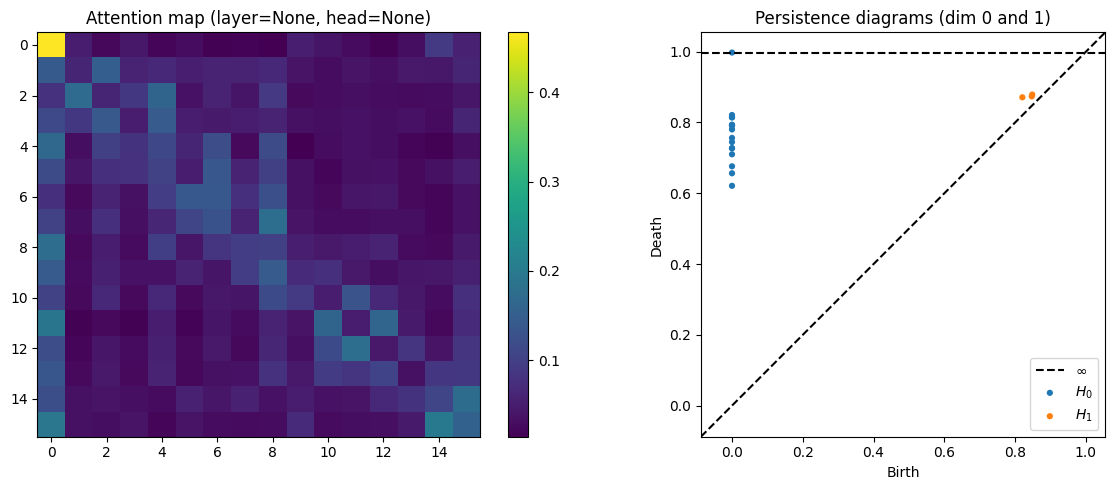

Perturbed text: in expressions of execution this drama is carefree and unmotivated .
Text sample: in expressions of execution this drama is carefree and unmotivated .
Attention map shape: (16, 16) (seq_len=16)


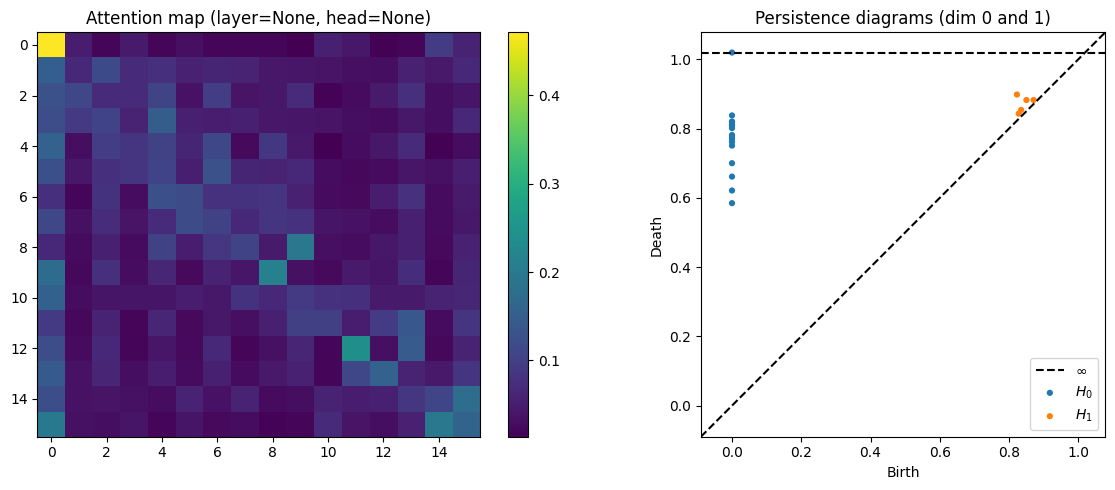

Original text: generates an enormous feeling of empathy for its characters .
Text sample: generates an enormous feeling of empathy for its characters .
Attention map shape: (12, 12) (seq_len=12)


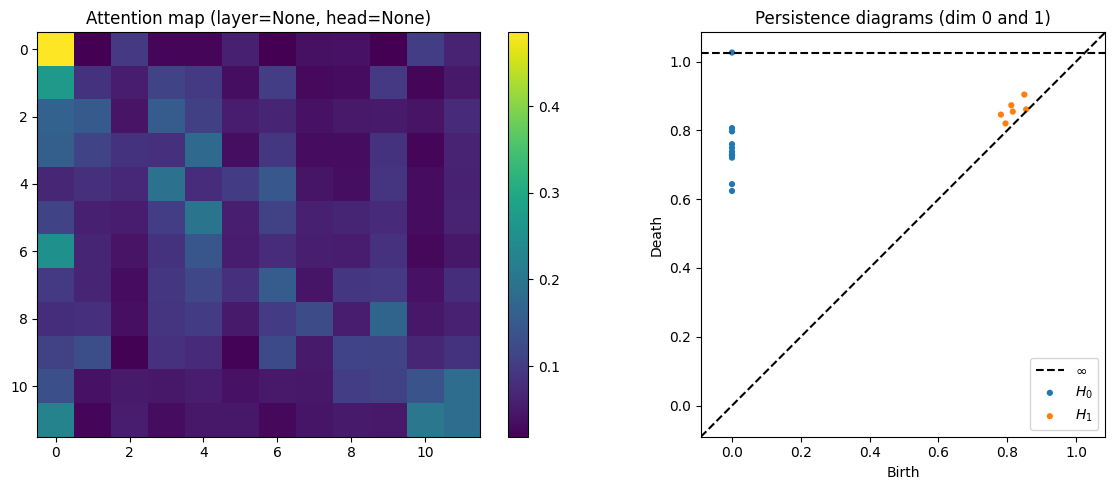

Perturbed text: generates an gargantuan feeling of empathy for its specifications .
Text sample: generates an gargantuan feeling of empathy for its specifications .
Attention map shape: (15, 15) (seq_len=15)


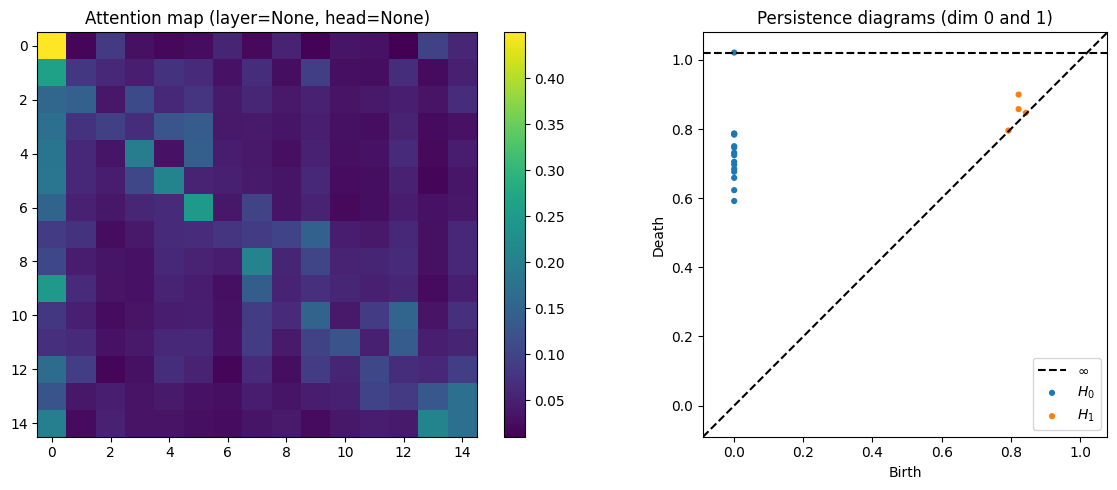

Original text: an enthralling , entertaining feature .
Text sample: an enthralling , entertaining feature .
Attention map shape: (11, 11) (seq_len=11)


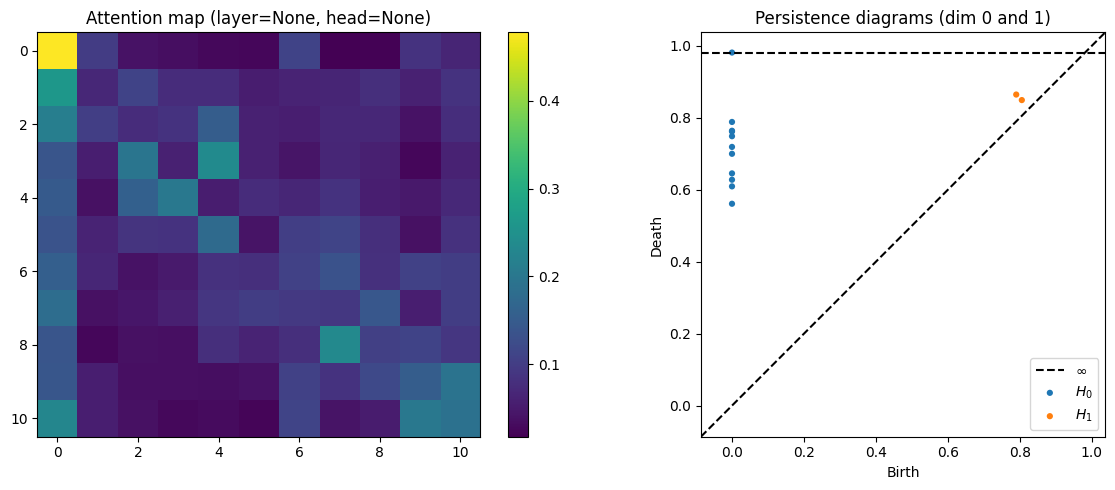

Perturbed text: an hallucinatory , funnier mannerisms .
Text sample: an hallucinatory , funnier mannerisms .
Attention map shape: (12, 12) (seq_len=12)


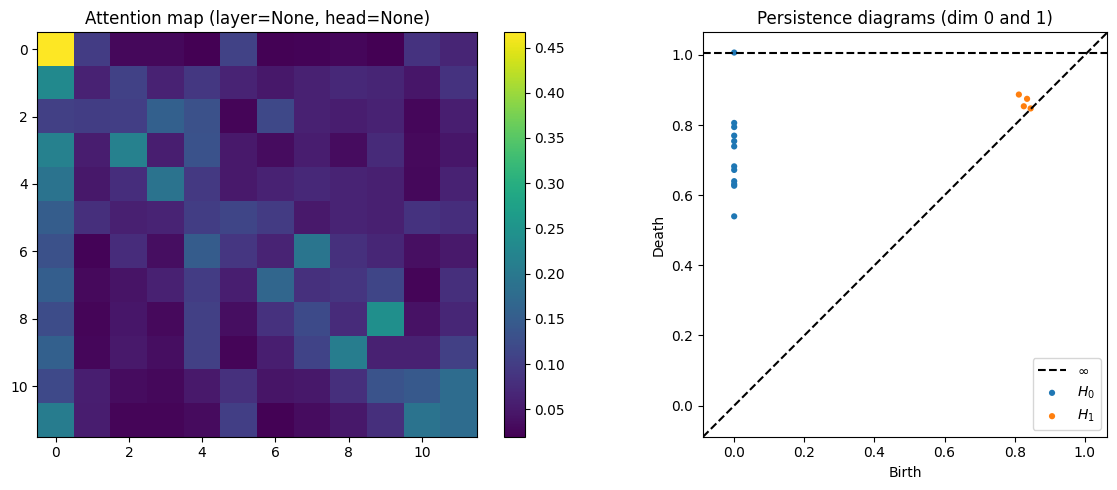

Original text: performances are potent , and the women's stories are ably intercut and involving .
Text sample: performances are potent , and the women's stories are ably intercut and involving .
Attention map shape: (20, 20) (seq_len=20)


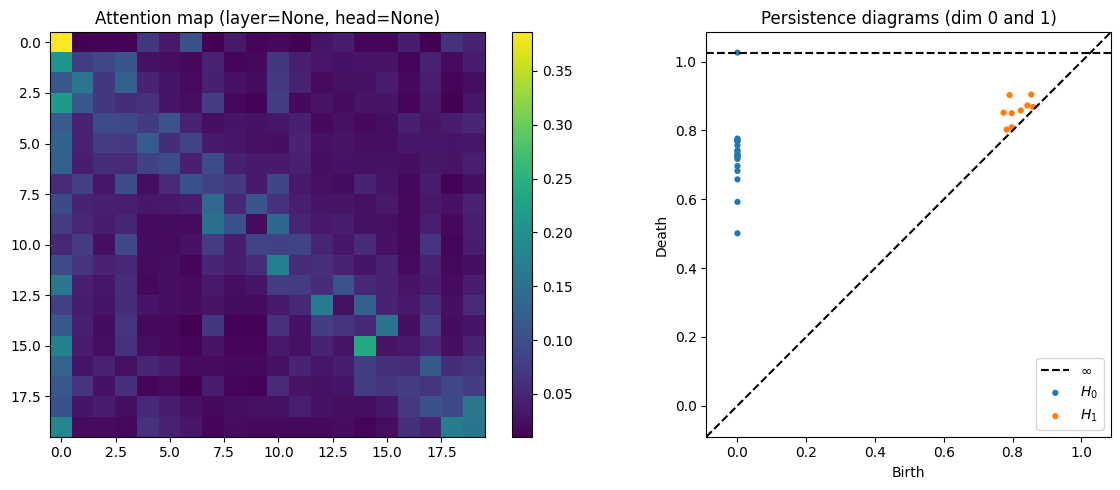

Perturbed text: performances are pompous , and the women's stories are ably intercut and covers .
Text sample: performances are pompous , and the women's stories are ably intercut and covers .
Attention map shape: (22, 22) (seq_len=22)


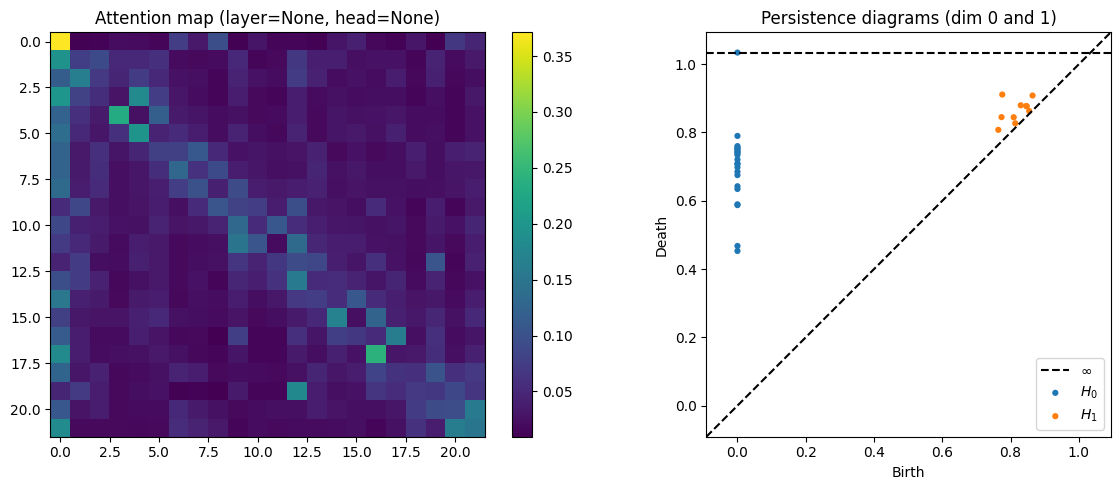

Original text: a highly watchable , giggly little story with a sweet edge to it .
Text sample: a highly watchable , giggly little story with a sweet edge to it .
Attention map shape: (18, 18) (seq_len=18)


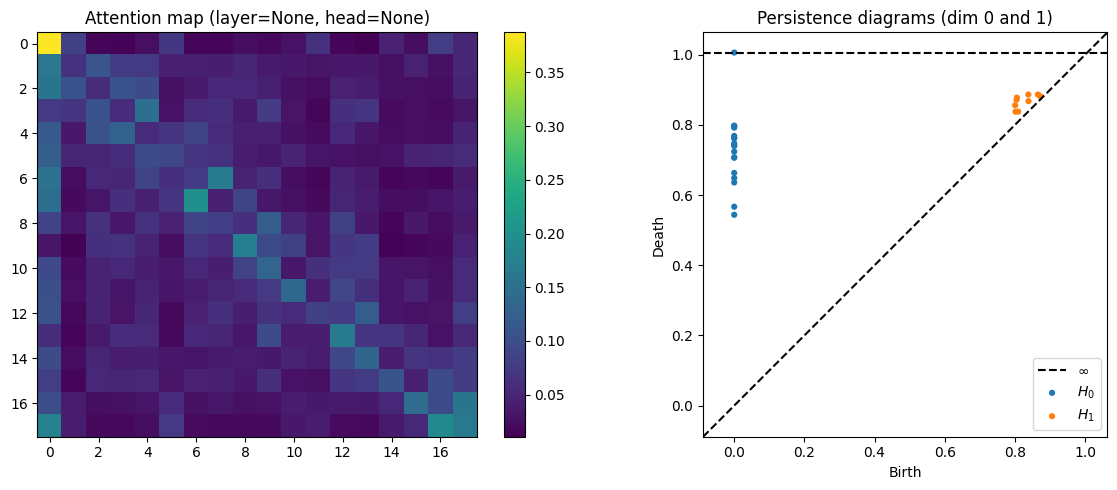

Perturbed text: a excessively watchable , giggly little conte with a crystallized edge to it .
Text sample: a excessively watchable , giggly little conte with a crystallized edge to it .
Attention map shape: (21, 21) (seq_len=21)


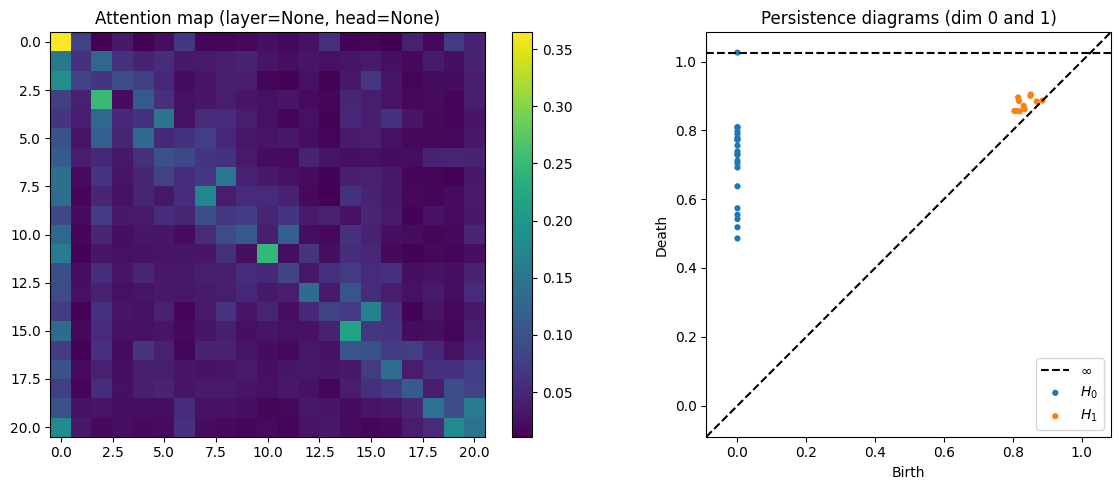

In [17]:
original_texts = df_success_sorted["original_text_clean"].tolist()
perturbed_texts = df_success_sorted["perturbed_text_clean"].tolist()
text_pairs = list(zip(original_texts, perturbed_texts))

n_pairs = 5
for i in range(n_pairs):
    original_text, perturbed_text = text_pairs[i]
    print(f"Original text: {original_text}")
    pipeline_compute_and_plot(original_text, 
                              tokenizer,
                              model)
    print(f"Perturbed text: {perturbed_text}")
    pipeline_compute_and_plot(perturbed_text, 
                              tokenizer,
                              model)